In [39]:
#network type
typeof="lstm"

In [40]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import shutil
import torch
import torch.nn.functional as F
from torch import nn
import torch.utils.data
import torch.optim as optim
import random
import time

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [41]:
previous="mit"
original="inhouse"

In [42]:
class ECGDataset(torch.utils.data.Dataset):
    
    def __init__(self,path):
        self.data=pd.read_csv(path,header=None)
        
    def __getitem__(self,idx):
        x=self.data.loc[idx,:186].values # removed the label
        return x
    
    def __len__(self):
        return len(self.data)

torch.Size([1600, 187]) torch.float64


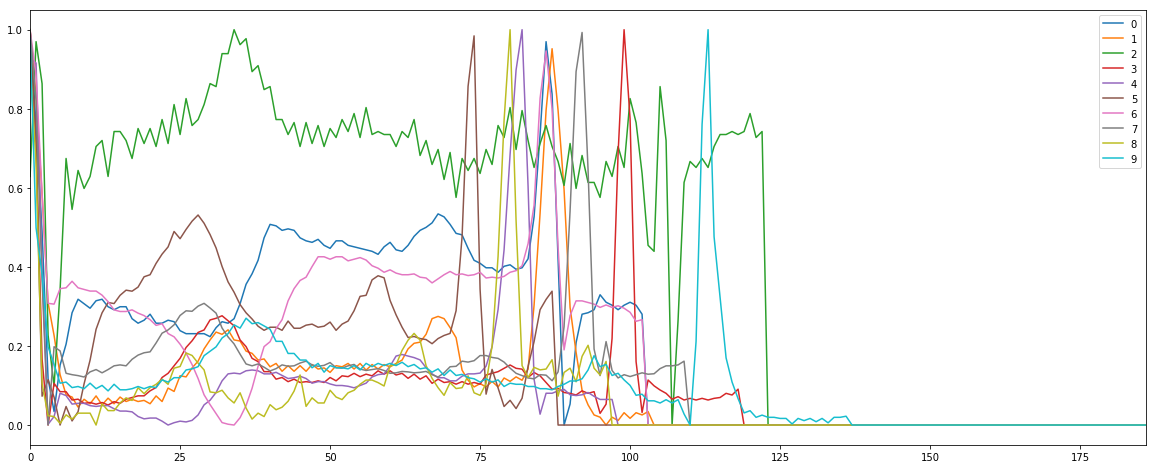

In [43]:
root_path="../input/ecgdatasets/anomaly/"+previous
new_path="../input/ecgdatasets/anomaly/"+original

cuda=torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")


class opt:
    batch_size=64
    workers=2
    lr=0.001
    normal_train_path=root_path+"/normal_train.csv"
    new_train_path=new_path+"/normal_train.csv"

df_normal_train=pd.read_csv(opt.new_train_path) #188 columns , last column class = 0
total_data=len(df_normal_train)

generator_ration=0.4
new_data=int(total_data*0.4)
old_data=total_data-new_data

normal_train_dset=ECGDataset(opt.normal_train_path)
trainloader=torch.utils.data.DataLoader(normal_train_dset,
                                       batch_size=new_data,
                                       shuffle=True,
                                        num_workers=opt.workers)

for x in trainloader:
    print(x.shape,x.dtype)
    x=x.numpy()
    x=pd.DataFrame(x)
    x.iloc[:10,:].T.plot(figsize=(20,8))
    plt.show() #plot to check the data pipeline is working well
    break

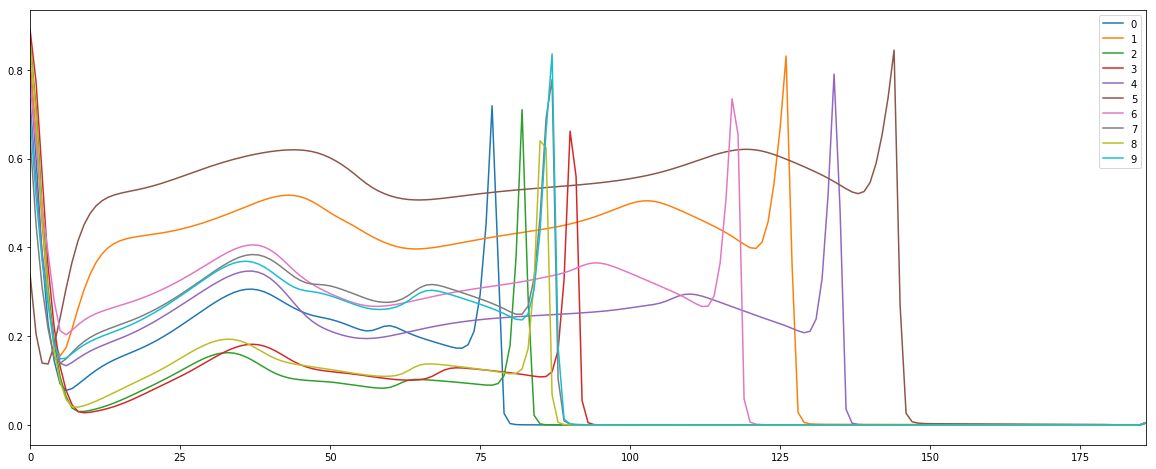

In [44]:
#change this
from models import LSTMEncoder
from models import loss_function
old_network=LSTMEncoder().to(device)
old_network.load_state_dict(torch.load("../models/anomaly_"+previous+".pt",map_location="cpu"))      

old_network.eval()
for i,signal in enumerate(trainloader):
    signal=signal.to(device).float()#batch_size,187
    old_network.zero_grad()
    out1,out2=old_network.Encoder(signal)
    break

    
a,b=new_data,20
r1,r2=out1.min(),out1.max()
noise1 = (r1 - r2) * torch.rand(a, b) + r2

a,b=new_data,20
r1,r2=out2.min(),out2.max()
noise2 = (r1 - r2) * torch.rand(a, b) + r2

out=old_network.Decoder(out1,out2)
out=torch.flip(out,dims=[1])
out=pd.DataFrame(out.detach().numpy())
out.iloc[:10,:].T.plot(figsize=(20,8))

In [45]:
#combining old data with new data
# append a column to out
# combine both dataset and save


##shuffle the data
##label class doesn't matter

out["187"]=0
df_merged=pd.DataFrame(np.vstack((df_normal_train.values,out.values)))
df_merged = df_merged.sample(frac=1).reset_index(drop=True)
df_merged.to_csv("../input/ecgdatasets/anomaly/"+previous+"_"+original+"/normal_train.csv",index=False)
print(df_merged.shape)

# mixing validation data
old_normal_valid=pd.read_csv("../input/ecgdatasets/anomaly/"+previous+"/normal_valid.csv")
old_patient_valid=pd.read_csv("../input/ecgdatasets/anomaly/"+previous+"/patient_valid.csv")

new_normal_valid=pd.read_csv("../input/ecgdatasets/anomaly/"+original+"/normal_valid.csv")
new_patient_valid=pd.read_csv("../input/ecgdatasets/anomaly/"+original+"/patient_valid.csv")

normal_valid_merge=np.vstack((old_normal_valid.values[:120],new_normal_valid.values[:120]))
patient_valid_merge=np.vstack((old_patient_valid.values[:120],new_patient_valid.values[:120]))

normal_valid_merge=pd.DataFrame(normal_valid_merge)
normal_valid_merge = normal_valid_merge.sample(frac=1).reset_index(drop=True)
normal_valid_merge.iloc[:,-1]=0
patient_valid_merge=pd.DataFrame(patient_valid_merge)
patient_valid_merge = patient_valid_merge.sample(frac=1).reset_index(drop=True)
patient_valid_merge.iloc[:,-1]=1


print(normal_valid_merge.shape,patient_valid_merge.shape)
normal_valid_merge.to_csv("../input/ecgdatasets/anomaly/"+previous+"_"+original+"/normal_valid.csv",index=False)
patient_valid_merge.to_csv("../input/ecgdatasets/anomaly/"+previous+"_"+original+"/patient_valid.csv",index=False)



(5600, 188)
(240, 188) (240, 188)
